In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.5335 - loss: 5.5364 - val_accuracy: 0.5400 - val_loss: 1.0222 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - accuracy: 0.6540 - loss: 0.8740 - val_accuracy: 0.5067 - val_loss: 1.0332 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - accuracy: 0.6846 - loss: 0.8376 - val_accuracy: 0.5133 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.6608 - loss: 0.8522 - val_accuracy: 0.5133 - val_loss: 1.0339 - learning_rate: 2.0000e-04
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.6973 - loss: 0.7889 - val_accuracy: 0.5200 - val_loss: 1.0027 - learning_rate: 2.0000e-04
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 301s 5s/step - accuracy: 0.6672 - loss: 0.8203 - val_accuracy: 0.4933 - val

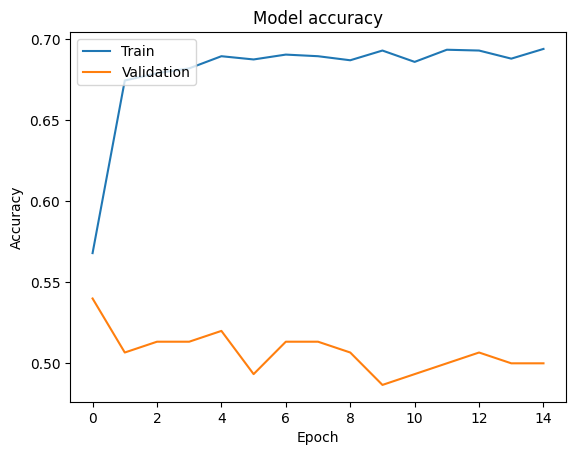

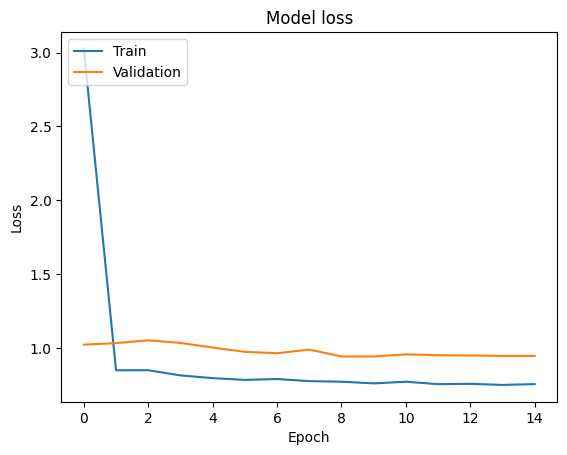

In [54]:
# Define the path to the directories
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators that load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Build the model using VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),  # High dropout to prevent overfitting
    Dense(3, activation='softmax')  # One output per class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)

# Plotting training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [3]:
# After training your model, save it like this:
if 'model' in locals():
    model.save('model/vgg19_model.h5')
else:
    print("Model not defined or trained yet.")

NameError: name 'model' is not defined

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import load_model

def load_and_prepare_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)  # Preprocess for VGG19

def predict_mole(image_path, model_path):
    # Load the VGG19 model
    model = load_model(model_path)
    
    # Prepare the image
    prepared_image = load_and_prepare_image(image_path, target_size=(224, 224))
    
    # Make prediction
    predictions = model.predict(prepared_image)
    predicted_class_indices = np.argmax(predictions, axis=1)
    
    # Assuming class indices are {0: 'Benign', 1: 'Malignant', 2: 'Other'}
    labels = {0: 'Benign', 1: 'Malignant', 2: 'Other'}
    predicted_label = labels[predicted_class_indices[0]]
    
    return predicted_label

# Example usage:
model_path = 'model/vgg19_model.h5'
image_path = 'user_image/test.jpg'

result = predict_mole(image_path, model_path)
print(f"The uploaded mole is predicted to be: {result}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model/vgg19_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)